In [1]:
# Create IRS/lists/IRS_metal_test.list for our usage
from pathlib import Path

OG_LIST = 'IRS/lists/IRS_metal_test.list'
NEW_LIST = 'IRS/lists/IRS_restaurant_metal_test.list'

to_write = []
with Path(OG_LIST).open('r') as all_list:
    lines = all_list.readlines()
    for line in lines:
        if "restaurant" not in line:
            continue
        to_write.append(line.replace('SIRSDataset/restaurant', 'Restaurant'))

with Path(NEW_LIST).open('w') as f:
    for item in to_write:
        f.write("%s" % item)




/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


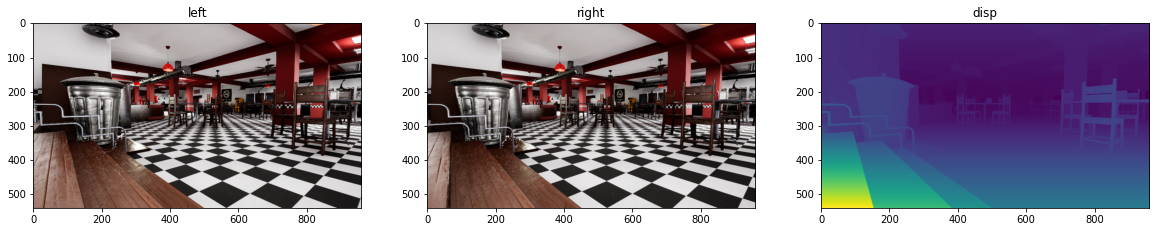

In [2]:
# Load the IRS/lists/IRS_metal_test.list file into the IRSDataset
%load_ext autoreload
%autoreload 2

from IRS.dataloader.IRSLoader import IRSDataset
import matplotlib.pyplot as plt


DATA_DIR = "/data"

dataset = IRSDataset(txt_file=NEW_LIST, root_dir=DATA_DIR, phase='visualize')
# good: 8, 12, 15, 26
sample = dataset[8]
im_l, im_r, disp = sample['img_left'], sample['img_right'], sample['gt_disp']

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1,3,1)
plt.title('left')
ax1.imshow(im_l.moveaxis(0, -1))
ax2 = fig.add_subplot(1,3,2)
plt.title('right')
ax2.imshow(im_r.moveaxis(0, -1))
ax3 = fig.add_subplot(1,3,3)
plt.title('disp')
ax3.imshow(disp.moveaxis(0, -1))

In [3]:
from collections import defaultdict
from typing import Dict, Callable
from tqdm import tqdm
import torch
import torch.nn as nn

def SSIM(x, y):
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    mu_x = nn.AvgPool2d(3, 1,1)(x)
    mu_y = nn.AvgPool2d(3, 1,1)(y)
    mu_x_mu_y = mu_x * mu_y
    mu_x_sq = mu_x.pow(2)
    mu_y_sq = mu_y.pow(2)

    sigma_x  = nn.AvgPool2d(3, 1,1)(x * x) - mu_x_sq
    sigma_y  = nn.AvgPool2d(3, 1,1)(y * y) - mu_y_sq
    sigma_xy = nn.AvgPool2d(3, 1,1)(x * y) - mu_x_mu_y

    SSIM_n = (2 * mu_x_mu_y + C1) * (2 * sigma_xy + C2)
    SSIM_d = (mu_x_sq + mu_y_sq + C1) * (sigma_x + sigma_y + C2)
    SSIM = SSIM_n / SSIM_d

    return torch.clamp((1 - SSIM) / 2, 0, 1)

def estimate_right(im_l, im_r, disp, depth_variance=0):
    '''
    im_l: [C(3), H, W]
    disp: [C(1), H, W]
    '''
    K = torch.tensor([[480, 0, 270], [0, 480, 480], [0, 0, 1]]).type_as(im_l)
    _, h, w = im_l.shape
    x_base = torch.linspace(0, w-1, w).repeat(h, 1)
    y_base = torch.linspace(0, h-1, h).repeat(w, 1).transpose(0, 1)
    # [H, W, 3]
    im_norm = (K.inverse() @ torch.stack((x_base, y_base, torch.ones_like(y_base)), dim=2).unsqueeze(-1)).squeeze()
    depth = ((0.1 * 480) / disp).moveaxis(0, -1)
    if depth_variance > 0:
        depth += (depth_variance**0.5)*torch.randn_like(depth)
    im_3d = im_norm * depth
    homo_im_3d = torch.concat((im_3d, torch.ones_like(depth)), dim=2)
    P = K @ torch.concat([torch.eye(3), torch.tensor([-0.1, 0, 0]).unsqueeze(1)], dim=1)
    homo_im_r_coords = (P @ homo_im_3d.unsqueeze(-1)).squeeze()
    im_r_coords = (homo_im_r_coords / homo_im_r_coords[:,:,-1].unsqueeze(-1))[:,:,:2]
    x = torch.zeros_like(im_r)
    x[2,:,:] = 1
    x = x.swapaxes(0, -1)
    index = tuple(im_r_coords.flatten(0,1).round().long().clip(0, 959).t())
    values = im_l.moveaxis(0,-1).flatten(0,1)
    est_r_occ = torch.index_put(x, index, values).swapaxes(0,1).moveaxis(-1, 0)
    valid_mask = torch.index_put(torch.zeros_like(x, dtype=torch.bool), index, torch.ones_like(values, dtype=torch.bool)).swapaxes(0,1).moveaxis(-1, 0)
    est_r = torch.where(valid_mask, est_r_occ, im_r)
    return est_r_occ, est_r

def eval_loss_functions(fns: Dict[str, Callable], dataset: IRSDataset, depth_variance=100):
    '''
    Returns a dict of quality ratios, smaller the better the loss function
    '''
    fn_to_ratios = defaultdict(list)
    for sample in tqdm(dataset):
        im_l, im_r, disp = sample['img_left'], sample['img_right'], sample['gt_disp']
        _, est_r = estimate_right(im_l, im_r, disp, depth_variance=0)
        _, dist_est_r = estimate_right(im_l, im_r, disp, depth_variance=depth_variance)
        for fn_name, fn in fns.items():
            fn_to_ratios[fn_name].append(fn(im_r, est_r) / fn(im_r, dist_est_r))
    return {k: (sum(v) / len(v)).item() for k,v in fn_to_ratios.items()}

In [4]:
l1_loss_fn = lambda gt, est: torch.abs(est - gt).mean()
ssim_loss_fn = lambda gt, est: SSIM(est, gt).mean()

results = eval_loss_functions(
    fns={'l1': l1_loss_fn, 'ssim': ssim_loss_fn}, 
    dataset=torch.utils.data.Subset(dataset, range(2)),
    depth_variance=10)
print(results)

100%|██████████| 2/2 [00:03<00:00,  1.91s/it]

{'l1': 0.4519466757774353, 'ssim': 0.24995273351669312}


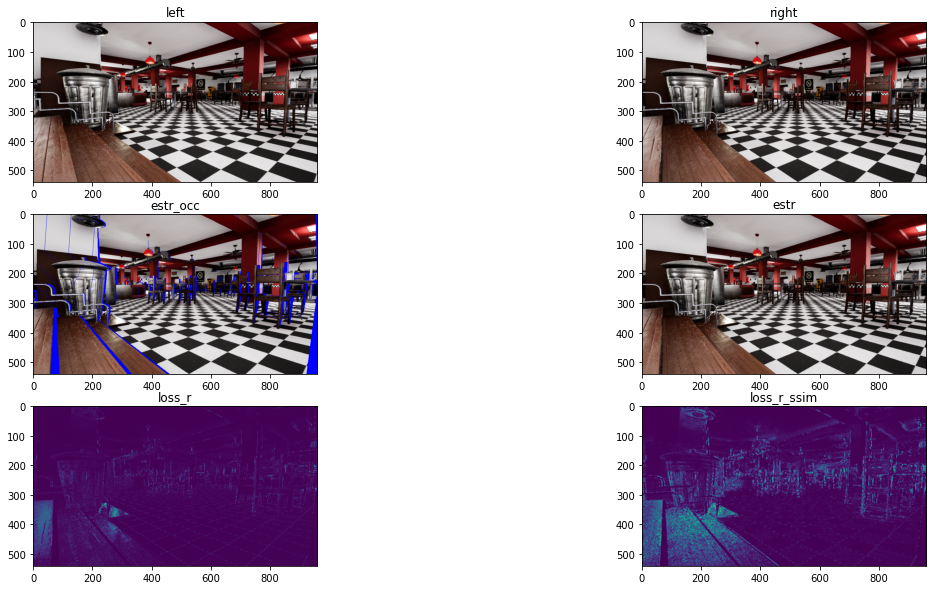

In [5]:
%matplotlib inline

est_r_occ, est_r = estimate_right(im_l, im_r, disp, depth_variance=0)
dist_est_r_occ, dist_est_r = estimate_right(im_l, im_r, disp, depth_variance=100)
l1_loss, dist_l1_loss = torch.abs(est_r - im_r), torch.abs(dist_est_r - im_r)
ssim_loss, dist_ssim_loss = SSIM(est_r, im_r), SSIM(dist_est_r, im_r)

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(3,2,1)
plt.title('left')
ax1.imshow(im_l.moveaxis(0, -1))
ax2 = fig.add_subplot(3,2,2)
plt.title('right')
ax2.imshow(im_r.moveaxis(0, -1))
ax3 = fig.add_subplot(3,2,3)
plt.title('estr_occ')
ax3.imshow(est_r_occ.moveaxis(0, -1))
ax3 = fig.add_subplot(3,2,4)
plt.title('estr')
ax3.imshow(est_r.moveaxis(0, -1))
ax3 = fig.add_subplot(3,2,5)
plt.title('loss_r')
ax3.imshow(l1_loss.norm(dim=0).squeeze().cpu())
ax3 = fig.add_subplot(3,2,6)
plt.title('loss_r_ssim')
ax3.imshow(ssim_loss.norm(dim=0).squeeze().cpu())